In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install contractions

In [ ]:
!pip install transformers

In [4]:
import pandas as pd
import re
import contractions
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import numpy as np
from datetime import date

In [6]:
interactions = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/interactions.xlsx', index_col=0)
sales = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/sales-pipeline.xlsx', index_col=0)

In [7]:
min_date = sales['Created Date'].min()
max_date = sales['Close Date'].max()

In [8]:
interactions = interactions[(interactions['InteractionDate']>min_date) & (interactions['InteractionDate']<max_date)]

We sort the interaction date in such way that the recent interactions are shown first, because the sales close depends on the final interacion, if the final interaction is positive then deal is tend to end positive.

In [9]:
interactions = interactions.sort_values(by="InteractionDate", ascending=False)

We only get the final interaction that happened between the sales agent and customer. To get only that data we remove all the prior interactions happened between them and keep only the last one.

To do this we create a new column that joins sales agent email and user email. When we remove all the duplicates based on that column, we will only have the last interaction between each pair.

In [10]:
interactions["sales_user"] = interactions["fromEmailId"] + interactions["toEmailId"]

In [11]:
interactions.drop_duplicates(subset=['sales_user'],inplace=True)
interactions.drop(['sales_user'], axis=1, inplace=True)

In [12]:
new_data =  pd.merge(sales,interactions,  how='left', left_on=['SalesAgentEmailID','ContactEmailID'], right_on = ['fromEmailId','toEmailId'])

The same way when we join both interactions and sales table,some duplicate tables will be created. So we only keep one row for each sales and user combination. We create a new column that concatenates sales and user email and we then remove all the duplicate entries.Once the use of column is done, we remove that too.

In [13]:
new_data["sales_user"] = new_data["SalesAgentEmailID"] + new_data["ContactEmailID"]

In [14]:
new_data.drop_duplicates(subset=['sales_user'],inplace=True)
new_data.drop(['sales_user'],axis=1,inplace=True)

In [15]:
new_data.shape

(1744, 15)

In [16]:
def contraction_fix(text):
  expanded_words = [contractions.fix(x) for x in text.split()]
  word =  ' '.join(expanded_words)
  return ' '.join(re.findall("[a-zA-Z]+", word))

In [17]:
new_data['Extracted Interaction Text'] = new_data['Extracted Interaction Text'].apply(contraction_fix)

We are gonna split our data into two based on the deals that are closed and the deals that are still in progress

In [18]:
data_progress = new_data[new_data['Deal_Stage'] == 'In Progress']

In [ ]:
data_progress.reset_index(inplace = True, drop = True)

We are gonna use the deal_stage column to create response_label column which will have binary value. If the deal is Won the response_type for that interaction will be 1 else 0.

In [19]:
data_closed = new_data[new_data['Deal_Stage'] != 'In Progress']

In [ ]:
data_closed.reset_index(inplace = True, drop = True)

In [20]:
def response_type(deal):
  if deal == 'Won':
    return 1
  else:
    return 0

In [ ]:
data_closed['response_label'] = data_closed['Deal_Stage'].apply(response_type)

We are now gonna train BERT model using the Extracted Interaction Text and response_label. 

In [22]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [23]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

In [24]:
def bert_encode(text):
    num_examples = len(text)

    sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array(text)])

    input_word_ids = tf.concat([sentence1], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_s1 = tf.zeros_like(sentence1)
    input_type_ids = tf.concat(
    [type_s1], axis=-1).to_tensor()
    
    inputs = {
    'input_word_ids': input_word_ids.to_tensor(),
    'input_mask': input_mask,
    'input_type_ids': input_type_ids
    }

    return inputs

In [25]:
train_input = bert_encode(data_closed['Extracted Interaction Text'].values)

In [26]:
train_input.keys()

dict_keys(['input_word_ids', 'input_mask', 'input_type_ids'])

In [27]:
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = build_model()

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
model.fit(train_input, data_closed.response_label.values, epochs = 6, verbose = 1, batch_size = 64, validation_split = 0.2)

In [31]:
test_input = bert_encode(data_progress['Extracted Interaction Text'])

In [32]:
test_input.keys()

dict_keys(['input_word_ids', 'input_mask', 'input_type_ids'])

In [ ]:
data_progress['response_label'] = [np.argmax(i) for i in model.predict(test_input)]

In [34]:
data_progress['response_label'].value_counts()

1    846
0     85
Name: response_label, dtype: int64

Now we have a proper train and test data that also has NLP included in it. As we have extracted a new feature from the NLP text, we don't need that anymore.

In [ ]:
data_closed.drop(['Extracted Interaction Text'], axis=1, inplace=True)
data_progress.drop(['Extracted Interaction Text'], axis=1, inplace=True)

We are going to create a new feature as age of sales, this is the difference between the sales start date and current date, 01 June 2019(as per pdf)

In [37]:
def date_diff(start_date):
  present_date = date(2019,6,1)
  return (present_date - start_date.date()).days

In [ ]:
data_progress['Deal_Age'] = data_progress['Created Date'].apply(date_diff)
data_closed['Deal_Age'] = data_closed['Created Date'].apply(date_diff)

We can not directly use the datetime field. We are going to process both Close and Create dates. We are going to extract the month and day of the week on which the sales were created and closed.

In [ ]:
data_progress['Create_month'] = data_progress['Created Date'].dt.month
data_progress['Close_month']  = data_progress['Close Date'].dt.month
data_progress['Create_day']   = data_progress['Created Date'].dt.dayofweek
data_progress['Close_day']    = data_progress['Close Date'].dt.dayofweek
data_progress['Close_year']   = data_progress['Close_Date'].dt.year 

In [ ]:
data_closed['Create_month'] = data_closed['Created Date'].dt.month
data_closed['Close_month']  = data_closed['Close Date'].dt.month
data_closed['Create_day']   = data_closed['Created Date'].dt.dayofweek
data_closed['Close_day']    = data_closed['Close Date'].dt.dayofweek

We are gonna drop the columns that we are not gonna use for sure. 

In [ ]:
data_closed.drop(['Opportunity_ID',	'SalesAgentEmailID',	'ContactEmailID',	'Created Date',	'Close Date','fromEmailId',	'toEmailId',	'InteractionDate'], axis=1, inplace=True)
data_progress.drop(['Opportunity_ID',	'SalesAgentEmailID',	'ContactEmailID',	'Created Date',	'Close Date','fromEmailId',	'toEmailId',	'InteractionDate'], axis=1, inplace=True)

In [47]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder

Encode all the columns to in such a way that it can be used inside ML model.

In [48]:
le = LabelEncoder()

In [ ]:
data_closed['InteractionType(Call/Email/SMS)'] = le.fit_transform(data_closed['InteractionType(Call/Email/SMS)']) 
data_progress['InteractionType(Call/Email/SMS)'] = le.fit_transform(data_progress['InteractionType(Call/Email/SMS)']) 

In [ ]:
data_closed['Deal_Stage'] = le.fit_transform(data_closed['Deal_Stage']) 

In [ ]:
data_closed['Sales_Agent'] = le.fit_transform(data_closed['Sales_Agent']) 
data_progress['Sales_Agent'] = le.fit_transform(data_progress['Sales_Agent']) 

data_closed['Product'] = le.fit_transform(data_closed['Product']) 
data_progress['Product'] = le.fit_transform(data_progress['Product']) 

In [58]:
data_closed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 813 entries, 0 to 7547
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Sales_Agent                      813 non-null    int64
 1   Deal_Stage                       813 non-null    int64
 2   Product                          813 non-null    int64
 3   Close_Value                      813 non-null    int64
 4   DateDiff                         813 non-null    int64
 5   InteractionType(Call/Email/SMS)  813 non-null    int64
 6   response_label                   813 non-null    int64
 7   Deal_Age                         813 non-null    int64
 8   Create_month                     813 non-null    int64
 9   Close_month                      813 non-null    int64
 10  Create_day                       813 non-null    int64
 11  Close_day                        813 non-null    int64
dtypes: int64(12)
memory usage: 82.6 KB


We have successfully Converted all our data to int data type.

Feature importance Analysis.We are gonna use Random Forest Classifier for this

In [59]:
X = data_closed.drop(['Deal_Stage'], axis=1) 
y = data_closed['Deal_Stage']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=101)

clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(X_train,y_train)
pred = clf_rf.predict(X_test)
ac = accuracy_score(y_test,pred)
print('Accuracy is: ',ac)

Accuracy is:  1.0


Our accuracy here is 100% this is because we are doing in-sample test. This results in over-fitting, but over here it is okay to have 100% accurasy because,we are not going to use this model. This is only for feature analysis purpose.

Feature ranking:
1. feature 5 (0.805085)
2. feature 2 (0.055461)
3. feature 6 (0.045577)
4. feature 3 (0.017255)
5. feature 1 (0.016979)
6. feature 0 (0.016621)
7. feature 7 (0.011831)
8. feature 8 (0.010575)
9. feature 10 (0.009594)
10. feature 9 (0.007095)
11. feature 4 (0.003926)


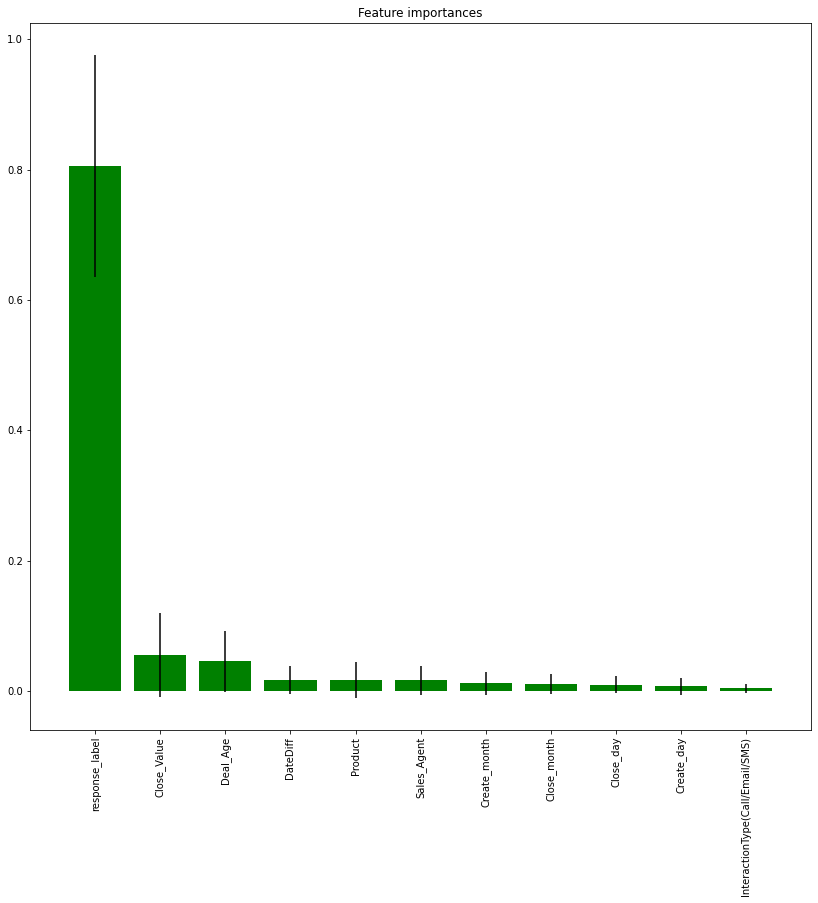

In [61]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(X_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Over here we can see that our response_label that we extracted using NLP data as the highest feature importance. So we are going to use all the features to train our actual Model.

In [ ]:
!pip install catboost

We are gonna use multiple Binary Classification models.

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

We have to drop the Deal_Stage and Close_year from the data_progress as Deal_Stage is what we want to predict and the year feature does not impact the target so much.

In [73]:
X = data_closed.drop(['Deal_Stage'], axis=1) 
y = data_closed['Deal_Stage']
X_test = data_progress.drop(['Deal_Stage','Close_year'], axis=1)

In [101]:
def model_selection(X, y, X_test,model):
    model = model()
    model.fit(X, y)
    pred = model.predict(X_test)
    return pred

In [99]:
solutions = pd.DataFrame()

In [ ]:
logistic_regression = model_selection(X, y, X_test, LogisticRegression)
solutions['log_reg'] = logistic_regression

In [103]:
gradient_boosting = model_selection(X, y, X_test, GradientBoostingClassifier)
solutions['gb'] = gradient_boosting

In [104]:
decision_tree = model_selection(X, y, X_test, DecisionTreeClassifier)
solutions['d_tress'] = decision_tree

In [106]:
random_forest = model_selection(X, y, X_test, RandomForestClassifier)
solutions['r_forest'] = random_forest

In [ ]:
catboost = model_selection(X, y, X_test, CatBoostClassifier)
solutions['catboost'] = catboost

We are going to select the best model out of all based on the output consistensy

In [109]:
solutions['log_reg'].value_counts()

1    846
0     85
Name: log_reg, dtype: int64

In [110]:
solutions['gb'].value_counts()

1    846
0     85
Name: gb, dtype: int64

In [113]:
solutions['d_tress'].value_counts()

1    846
0     85
Name: d_tress, dtype: int64

In [114]:
solutions['r_forest'].value_counts()

1    846
0     85
Name: r_forest, dtype: int64

In [115]:
solutions['catboost'].value_counts()

1    846
0     85
Name: catboost, dtype: int64

To our Suprise all our model had predicted the Win/Lost in the same percentage.So we are going with the most sophisticated and least memory consuming model, Random Forest. 

In [ ]:
data_progress['Deal_Stage'] = solutions['r_forest']

Now we can go ahead and find the sales.

First Problem : To find the Sales of next month after June, that is sales is July.


We get all the Sales that has close Month as July 2019. So that we can get the Won Sales for that month, sum the Close Value to get the Sales made that Month 

In [182]:
data_july = data_progress[(data_progress['Close_year'] == 2019) & (data_progress['Close_month'] == 7)]

data_july contains all deals that has closing month as july and year 2019. We then get all the Won Deal_Stage to find the sum of sales made this month

In [168]:
sales_july = data_july[data_july['Deal_Stage'] == 1]['Close_Value'].sum()

The Sales Made after One Month : 19,945

We have to now predict for Finanical Quarter, that is for upcoming three months after June, that is July, August, Spetember.

In [159]:
data_aug = data_progress[(data_progress['Close_year'] == 2019) & (data_progress['Close_month'] == 8)]

In [169]:
sales_aug = data_aug[data_aug['Deal_Stage'] == 1]['Close_Value'].sum()

The Sales Made on August Month : 21,021

In [166]:
data_sep = data_progress[(data_progress['Close_year'] == 2019) & (data_progress['Close_month'] == 9)]

In [170]:
sales_sep = data_sep[data_sep['Deal_Stage'] == 1]['Close_Value'].sum()

The Sales Made on Septempber Month : 22,510

Now, let's aggregate all three month sales to find the Quarter Financial Year Sale

In [172]:
Quarter_sale = (sales_july + sales_aug + sales_sep)

In [173]:
Quarter_sale

63476

The Quarter Financial Year Sale is expected to be : 63,476

Now we have to calculate the sales till End of Financial Year 2019. That is from June 2019 to December 2019.

In [197]:
data_oct = data_progress[(data_progress['Close_year'] == 2019) & (data_progress['Close_month'] == 10)]

In [200]:
sales_oct = data_oct[data_oct['Deal_Stage'] == 1]['Close_Value'].sum()

In [207]:
data_nov = data_progress[(data_progress['Close_year'] == 2019) & (data_progress['Close_month'] == 11)]

In [208]:
sales_nov = data_nov[data_nov['Deal_Stage'] == 1]['Close_Value'].sum()

In [209]:
data_dec = data_progress[(data_progress['Close_year'] == 2019) & (data_progress['Close_month'] == 12)]

In [211]:
sales_dec = data_dec[data_dec['Deal_Stage'] == 1]['Close_Value'].sum()

Now we have all the sales from July 2019 to December 2019.

In [213]:
Yearly_Sales = sales_july + sales_aug + sales_sep + sales_oct + sales_nov + sales_dec

In [214]:
Yearly_Sales

167193

The Predicted Sales from July-December is : 1,67,193

The data has been give only till 2019 end and the prediction has been made accordingly.